# Classification

Once we have objects localized, we can try using a neural networks for image classification. As we have many different coin types with head and tails, we decided to split the task into:

1. classify coins to EUR, CHF or OOD;
2. classify specific coin type per currency -> separate models for EUR and CHF.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [82]:
import torch

import numpy as np
import albumentations as A

from scripts.models import CoinClassifier
from scripts.config import ID_TO_LABEL, ID_TO_CCY, ID_TO_EUR
from scripts.viz import plot_images
from scripts.training import train_model, get_best_available_device
from scripts.utils import split_data, get_images_from_coco, ClassificationDataset, plot_training, get_class

from torch.utils.data import DataLoader
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR

## Hyperparameters and Config

In [36]:
# let's specify paths to training images and masks
images_path = "../data/train"
coins_path = "../data/classification"
labels_path = "../data/classification/labels.json"

annotation_path = "../data/annotations.json"
cls_path = "../data/classification"

In [37]:
# training hyperparameters
batch_size = 8
lr = 0.001
momentum = 0.9

## Transformations

We first define data augmentations for more robust model. Since our backbones are pretrained on Imagenet, we apply dataset specific normalization to the transformations.

In [53]:
# cut coins from images if necessary and save them as separate images
get_images_from_coco(images_path, annotation_path, cls_path)

Files already there, good to go!


In [39]:
# define data augmentation for train and validation
train_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.RandomRotate90(),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True)
])

valid_tf = A.Compose([
    A.Resize(width=224, height=224, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True)  # imagenet specific
])

## Modelling

### Predicting Currency

We first build a classifier that will separate between EUR, CHF and OOD.

#### Datasets and DataLoaders

In [55]:
# split the image paths into train and validation
images_train, images_val, labels_train, labels_val = split_data(coins_path, 0.2, "classification", labels_path, "ccy")

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

We use `Segmentation Models Pytorch` for model generation, then we define training arguments and train the model

In [56]:
model = CoinClassifier(num_classes=3, coin_type="ccy")

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [58]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=40
)

Epoch:   1. Train.      Loss: 1.820 | f1: 0.487: 100%|██████████| 39/39 [00:05<00:00,  7.01it/s]
Epoch:   1. Validation. Loss: 0.979 | f1: 0.473: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]
Epoch:   2. Train.      Loss: 1.121 | f1: 0.571: 100%|██████████| 39/39 [00:05<00:00,  7.16it/s]
Epoch:   2. Validation. Loss: 0.714 | f1: 0.805: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]
Epoch:   3. Train.      Loss: 0.757 | f1: 0.692: 100%|██████████| 39/39 [00:05<00:00,  7.36it/s]
Epoch:   3. Validation. Loss: 0.636 | f1: 0.793: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]
Epoch:   4. Train.      Loss: 0.783 | f1: 0.718: 100%|██████████| 39/39 [00:05<00:00,  7.28it/s]
Epoch:   4. Validation. Loss: 0.525 | f1: 0.793: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]
Epoch:   5. Train.      Loss: 0.671 | f1: 0.750: 100%|██████████| 39/39 [00:06<00:00,  6.20it/s]
Epoch:   5. Validation. Loss: 0.506 | f1: 0.830: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]
Epoch:   6. Train.      Loss: 

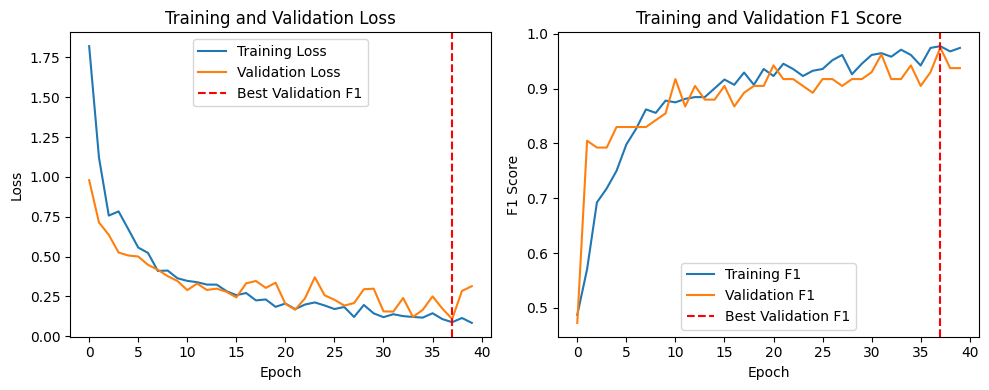

In [59]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

#### Inference

Let's see some of the examples of how well the model does on evaluation dataset.

In [ ]:
eval_loader = DataLoader(val_ds, batch_size=4, shuffle=False)  # TODO: filter
id_to_label = np.vectorize(lambda x: ID_TO_CCY.get(x, "Unknown"))

for images, labels, radii in eval_loader:
    
    predicted = get_class(model, images, radii, id_to_label)
    actual = id_to_label(labels.numpy())

    img_labels = [f"pred: {a1}, actual: {a2}" for a1, a2 in zip(predicted, actual)]
    images = torch.clamp(images, 0, 1).cpu().numpy()

    images_dict = dict(zip(img_labels, images))

    plot_images(**images_dict)

### Predicting EUR

Now we can build a classifier to distinguish between EUR coin types.

#### Datasets and DataLoaders

In [72]:
# split the image paths into train and validation
images_train, images_val, labels_train, labels_val = split_data(coins_path, 0.2, "classification", labels_path, "eur")

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [78]:
model = CoinClassifier(num_classes=8, coin_type="eur")

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
# train the model

In [80]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=80
)

Epoch:   1. Train.      Loss: 2.875 | f1: 0.125: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
Epoch:   1. Validation. Loss: 1.951 | f1: 0.150: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]
Epoch:   2. Train.      Loss: 2.484 | f1: 0.175: 100%|██████████| 20/20 [00:03<00:00,  6.48it/s]
Epoch:   2. Validation. Loss: 1.692 | f1: 0.425: 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]
Epoch:   3. Train.      Loss: 1.919 | f1: 0.300: 100%|██████████| 20/20 [00:03<00:00,  6.12it/s]
Epoch:   3. Validation. Loss: 1.589 | f1: 0.450: 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]
Epoch:   4. Train.      Loss: 1.771 | f1: 0.300: 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]
Epoch:   4. Validation. Loss: 1.504 | f1: 0.500: 100%|██████████| 5/5 [00:00<00:00,  7.51it/s]
Epoch:   5. Train.      Loss: 1.641 | f1: 0.406: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s]
Epoch:   5. Validation. Loss: 1.377 | f1: 0.625: 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]
Epoch:   6. Train.      Loss: 1.346 | f1

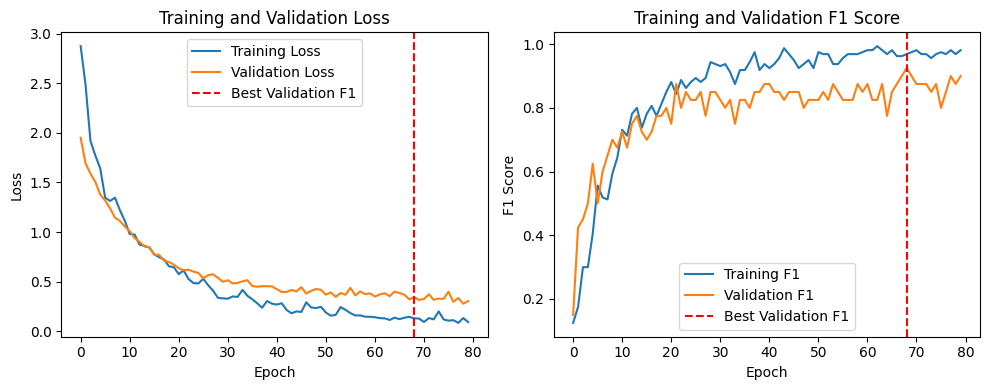

In [81]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

#### Inference

Let's see some of the examples of how well the EUR model does on evaluation dataset.

In [ ]:
eval_loader = DataLoader(val_ds, batch_size=4, shuffle=False)  # TODO: filter
id_to_label = np.vectorize(lambda x: ID_TO_EUR.get(x, "Unknown"))

for images, labels, radii in eval_loader:
    predicted = get_class(model, images, radii, id_to_label)
    actual = id_to_label(labels.numpy())

    img_labels = [f"pred: {a1}, actual: {a2}" for a1, a2 in zip(predicted, actual)]
    images = torch.clamp(images, 0, 1).cpu().numpy()

    images_dict = dict(zip(img_labels, images))

    plot_images(**images_dict)

### Predicting CHF

Now we can build a classifier to distinguish between CHF coin types.

#### Datasets and DataLoaders

In [84]:
# split the image paths into train and validation
images_train, images_val, labels_train, labels_val = split_data(coins_path, 0.2, "classification", labels_path, "chf")

# get train and val dataset instances
train_ds = ClassificationDataset(
    image_paths=images_train,
    labels=labels_train,
    transform=train_tf,
)

val_ds = ClassificationDataset(
    image_paths=images_val,
    labels=labels_val,
    transform=valid_tf,
)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)

#### Modelling

In [85]:
model = CoinClassifier(num_classes=8, coin_type="chf")

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [87]:
# train the model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    criterion,
    optimizer,
    scheduler,
    num_epochs=80
)

Epoch:   1. Train.      Loss: 2.786 | f1: 0.170: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
Epoch:   1. Validation. Loss: 2.144 | f1: 0.125: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]
Epoch:   2. Train.      Loss: 2.789 | f1: 0.125: 100%|██████████| 14/14 [00:01<00:00,  7.35it/s]
Epoch:   2. Validation. Loss: 1.699 | f1: 0.323: 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]
Epoch:   3. Train.      Loss: 2.240 | f1: 0.185: 100%|██████████| 14/14 [00:01<00:00,  7.60it/s]
Epoch:   3. Validation. Loss: 1.512 | f1: 0.396: 100%|██████████| 4/4 [00:00<00:00,  9.09it/s]
Epoch:   4. Train.      Loss: 1.914 | f1: 0.286: 100%|██████████| 14/14 [00:01<00:00,  7.19it/s]
Epoch:   4. Validation. Loss: 1.495 | f1: 0.385: 100%|██████████| 4/4 [00:00<00:00,  8.88it/s]
Epoch:   5. Train.      Loss: 2.004 | f1: 0.247: 100%|██████████| 14/14 [00:01<00:00,  7.09it/s]
Epoch:   5. Validation. Loss: 1.416 | f1: 0.448: 100%|██████████| 4/4 [00:00<00:00,  9.49it/s]
Epoch:   6. Train.      Loss: 1.573 | f1

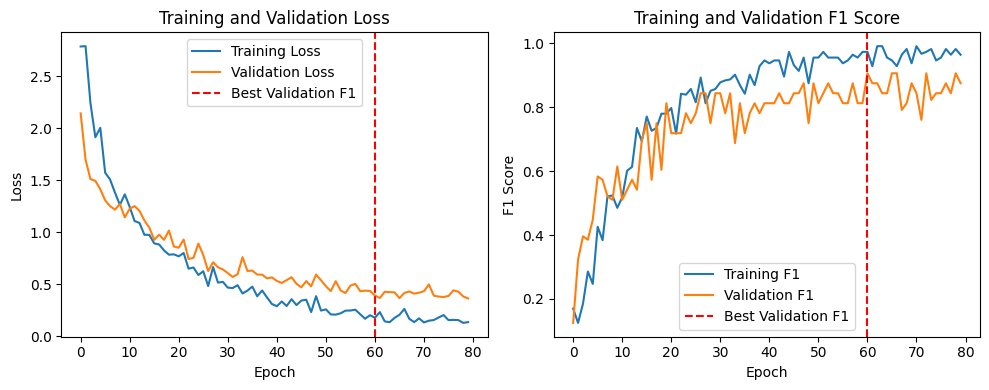

In [88]:
plot_training(train_losses, valid_losses, train_f1s, valid_f1s)

#### Inference

In [ ]:
eval_loader = DataLoader(val_ds, batch_size=4, shuffle=False)  # TODO: filter
id_to_label = np.vectorize(lambda x: ID_TO_LABEL.get(x, "Unknown"))

for images, labels, radii in eval_loader:
    predicted = get_class(model, images, radii, id_to_label)
    actual = id_to_label(labels.numpy())

    img_labels = [f"pred: {a1}, actual: {a2}" for a1, a2 in zip(predicted, actual)]
    images = torch.clamp(images, 0, 1).cpu().numpy()

    images_dict = dict(zip(img_labels, images))

    plot_images(**images_dict)